### Finetune GPT-4o Vision

**Steps:**
1. Use the pre-trained model
2. Prepare training data
3. Finetune the pre-trained model
4. Use the fine-tuned model

### 1. Use the pre-trained model

In [1]:
from openai import OpenAI
client = OpenAI()

In [93]:
image_url="https://images.pickles.com.au/image/upload/f_auto,q_auto,w_2000/c_scale,g_south_east,l_pickles-logo-white_mipoap.png,o_60,w_0.4,fl_relative,x_0.02,y_0.02,fl_region_relative/v1726789702/asostfbejshw7ekod5xa.jpg"
image_url

'https://images.pickles.com.au/image/upload/f_auto,q_auto,w_2000/c_scale,g_south_east,l_pickles-logo-white_mipoap.png,o_60,w_0.4,fl_relative,x_0.02,y_0.02,fl_region_relative/v1726789702/asostfbejshw7ekod5xa.jpg'

In [3]:
response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image, answer in one senetence?"},
        {
          "type": "image_url",
          "image_url": {
            "url": image_url,
          },
        },
      ],
    }
  ],
  max_tokens=100,
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image shows a grey sports car with significant front-end damage parked on a wet surface.', role='assistant', function_call=None, tool_calls=None, refusal=None))


In [13]:
image_path = "car_damage/bumper_dent--minor--0001.jpeg"

In [14]:
import base64

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(image_path)
image_url  = f"data:image/jpeg;base64,{base64_image}"

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image, answer in one senetence?"},
        {
          "type": "image_url",
          "image_url": {
            "url": image_url,
          },
        },
      ],
    }
  ],
  max_tokens=100,
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image shows the rear damage of a dark-colored car, likely due to a collision.', role='assistant', function_call=None, tool_calls=None, refusal=None))


### 2. Prepare training data

#### Usecase
Automobile insurace company - Automatic damage detection & asssessment
- damaged_part
- damage_type
- damage_severity

In [ ]:
{
  "messages": [
    { "role": "system", 
     "content": "You are an assistant that identifies which part of the car is damaged and the severity level of the damage" },
    { "role": "user", 
     "content": "Identify which part of the car is damaged and the severity level of the damage."},
    { "role": "user", 
     "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": image_url
          }
        }
      ] 
    },
    { "role": "assistant", "content": "doors" }
  ]
}


In [95]:
from pydantic import BaseModel

class damage_output(BaseModel):
    damaged_part: str
    damge_type: str
    damage_severity: str

In [96]:
import glob
import json

with open("car_damage_train.jsonl", "w") as fp:    
    for image_path in glob.iglob('car_damage/*'):
        base64_image = encode_image(image_path)
        image_url  = f"data:image/jpeg;base64,{base64_image}"

        ground_truth = image_path.split("/")[-1][:-11].split("--")
        ground_truth = {"damaged_part": ground_truth[0], "damage_type": ground_truth[1], "damage_severity": ground_truth[2]}

        #image_url="https://images.pickles.com.au/image/upload/f_auto,q_auto,w_2000/c_scale,g_south_east,l_pickles-logo-white_mipoap.png,o_60,w_0.4,fl_relative,x_0.02,y_0.02,fl_region_relative/v1726789702/asostfbejshw7ekod5xa.jpg"
        
        example = {
          "messages": [
            { "role": "system", 
             "content": "You are an assistant that identifies which part of the car is damaged, damage type and the severity level of the damage" },
            { "role": "user", 
             "content": "Identify which part of the car is damaged and the severity level of the damage. \
                        Possible values for the damaged parts are: [bumper, door, glass] \
                        Possible values for the damage types are: [dent, scratch, shatter] \
                        Possible values for the severity level are: [minor, major] \
                        "},
            { "role": "user", 
             "content": [
                {
                  "type": "image_url",
                  "image_url": {
                    "url": image_url
                  }
                }
              ] 
            },
            { "role": "assistant", "content": f"{ground_truth}" }
          ],
            #response_format=damage_output,
        }

        example_str = json.dumps(example)  
        fp.write(example_str + "\n")

{"messages": [{"role": "system", "content": "You are an assistant that identifies which part of the car is damaged, damage type and the severity level of the damage"}, {"role": "user", "content": "Identify which part of the car is damaged and the severity level of the damage.                         Possible values for the damaged parts are: [bumper, door, glass]                         Possible values for the damage types are: [dent, scratch, shatter]                         Possible values for the severity level are: [minor, major]                         "}, {"role": "user", "content": [{"type": "image_url", "image_url": {"url": ""}}]}, {"role": "assistant", "content": "{'damaged_part': 'door', 'damage_type': 'scratch', 'damage_severity': 'minor'}"}]}

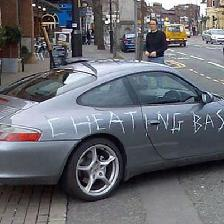

In [72]:
!head -n 1 car_damage_train.jsonl

{"messages": [{"role": "system", "content": "You are an assistant that identifies which part of the car is damaged, damage type and the severity level of the damage"}, {"role": "user", "content": "Identify which part of the car is damaged and the severity level of the damage.                         Possible values for the damaged parts are: [bumper, door, glass]                         Possible values for the damage types are: [dent, scratch, shatter]                         Possible values for the severity level are: [minor, major]                         "}, {"role": "user", "content": [{"type": "image_url", "image_url": {"url": ""}}]}, {"role": "assistant", "content": "{'damaged_part': 'door', 'damage_type': 'scratch', 'damage_severity': 'minor'}"}]}

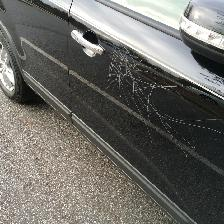

In [73]:
!tail -n 1 car_damage_train.jsonl

### 2. Finetune model


In [74]:
response = client.files.create(
    file=open("car_damage_train.jsonl", "rb"),
    purpose="fine-tune"
)
print(response)

FileObject(id='file-To5fusadl3iSeI7h373inAwJ', bytes=313245, created_at=1727994309, filename='car_damage_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [75]:
file_id = response.id
print(file_id)

file-To5fusadl3iSeI7h373inAwJ


In [76]:
# response = client.files.delete(file_id)
# response

In [77]:
response = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-4o-2024-08-06",
    hyperparameters={"n_epochs": 1}
    #validation_file
)

print("Fine-tune job is started")
ft_job_id = response.id


Fine-tune job is started


In [82]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=ft_job_id, limit=10)
response

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-ungwMznFBoet4owazVfnXvka', created_at=1727994898, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-c9xQyPII2tlHbUeJHDBQ0Oo3', created_at=1727994894, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-gTxHyBwAHpjD5CJliEr8927I', created_at=1727994862, level='info', message='Step 13/13: training loss=0.13', object='fine_tuning.job.event', data={'step': 13, 'train_loss': 0.12681572139263153, 'total_steps': 13, 'train_mean_token_accuracy': 0.9615384340286255}, type='metrics'), FineTuningJobEvent(id='ftevent-USGAoYMyGam2CqXpdHZg0HHz', created_at=1727994862, level='info', message='Step 12/13: training loss=0.17', object='fine_tuning.job.event', data={'step': 12, 'train_loss': 0.16928020119667053, 'total_steps': 13, 'train_mean_token_

In [79]:
#dir(response)

In [83]:
response = client.fine_tuning.jobs.retrieve(ft_job_id)
print(response)

FineTuningJob(id='ftjob-3IQrF0olbpZgypJGmzSPboeM', created_at=1727994311, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-2024-08-06:personal::AEOhKzIQ', finished_at=1727994892, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-skZHDYN1xmsxAl538Hbgo1ud', result_files=['file-4Qe4zEMfCQF97RiNLLVRnpLu'], seed=1680275706, status='succeeded', trained_tokens=5196, training_file='file-To5fusadl3iSeI7h373inAwJ', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)


In [84]:
result_files = response.result_files
result_files

['file-4Qe4zEMfCQF97RiNLLVRnpLu']

### 3. Use the finetuned model

In [85]:
fine_tuned_model = response.fine_tuned_model
fine_tuned_model

'ft:gpt-4o-2024-08-06:personal::AEOhKzIQ'

In [89]:
image_url="https://images.pickles.com.au/image/upload/f_auto,q_auto,w_2000/c_scale,g_south_east,l_pickles-logo-white_mipoap.png,o_60,w_0.4,fl_relative,x_0.02,y_0.02,fl_region_relative/v1726789702/asostfbejshw7ekod5xa.jpg"

In [92]:
response = client.chat.completions.create(
  model=fine_tuned_model,
  messages=[
    {
      "role": "user",
      "content": [
        {
            "type": "text",
            "text": "Identify which part of the car is damaged and the severity level of the damage. \
                        Possible values for the damaged parts are: [bumper, door, glass] \
                        Possible values for the damage types are: [dent, scratch, shatter] \
                        Possible values for the severity level are: [minor, major] \
                        "},
        {
          "type": "image_url",
          "image_url": {
            "url": image_url,
          },
        },
      ],
    }
  ],
  max_tokens=100,
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='- Damaged Part: bumper\n- Damage Type: dent\n- Severity Level: major', role='assistant', function_call=None, tool_calls=None, refusal=None))


In [98]:
#client.models.delete(fine_tuned_model)

**Advantages**
- Higher quality results than prompting
- Ability to train on more examples than can fit in a prompt
- Token savings due to shorter prompts
- Lower latency requests


**Disadvantages**
- Expensive & handware
- more LLMOps